## I/ DaTscan Images

### Imports

In [1]:
import os
import pydicom
import matplotlib.pyplot as plt

import subprocess
import nibabel as nib
import numpy as np

from skimage.restoration import denoise_nl_means, estimate_sigma

### display the original images (DICOM)

In [2]:
def display_dicom_image(dicom_file, axis="x"):
    try:
        ds = pydicom.dcmread(dicom_file)
        img = ds.pixel_array

        # Take middle slice in x-axis
        if axis == "x":
            x_middle = img.shape[0] // 2
            img_slice = img[x_middle, :, :]
        # Take middle slice in y-axis
        elif axis == "y":
            y_middle = img.shape[1] // 2
            img_slice = img[:, y_middle, :]

        # Take middle slice in z-axis
        else:
            z_middle = img.shape[2] // 2
            img_slice = img[:, :, z_middle]


        plt.imshow(img_slice, cmap='gray')
        plt.title(f"DICOM: {os.path.basename(dicom_file)}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Failed to read {dicom_file}: {e}")

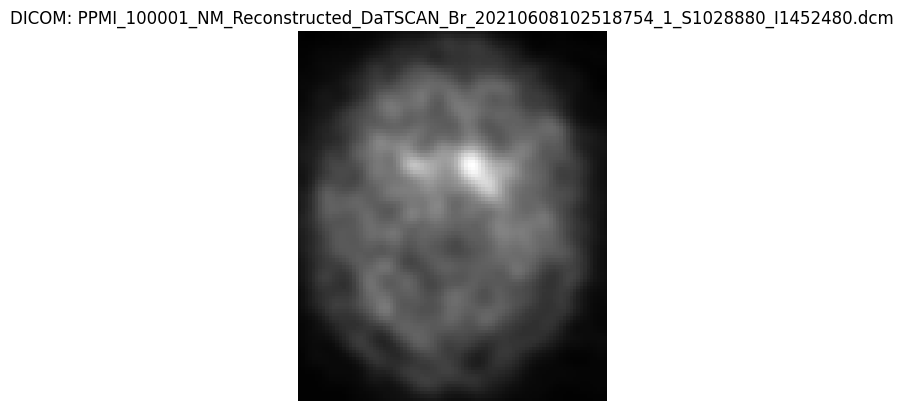

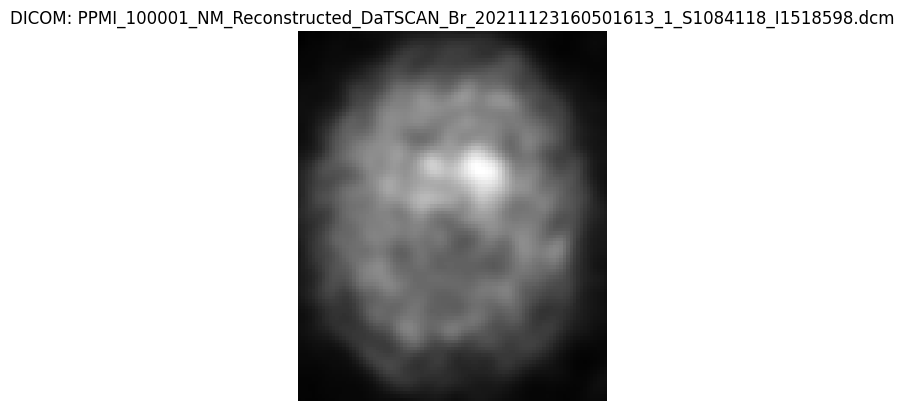

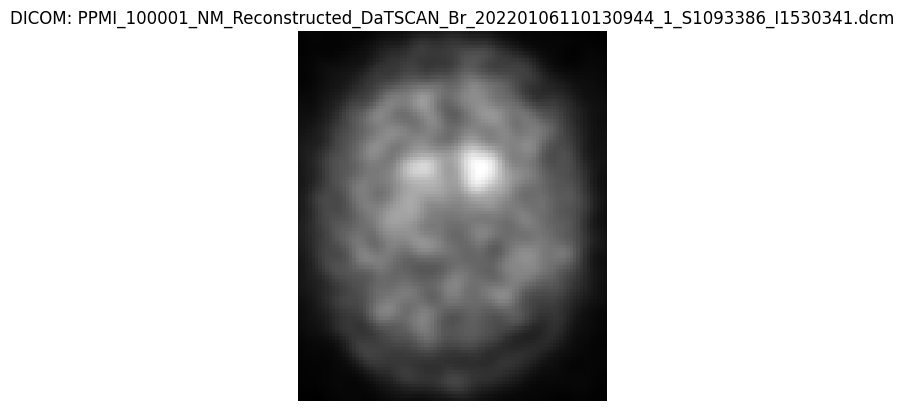

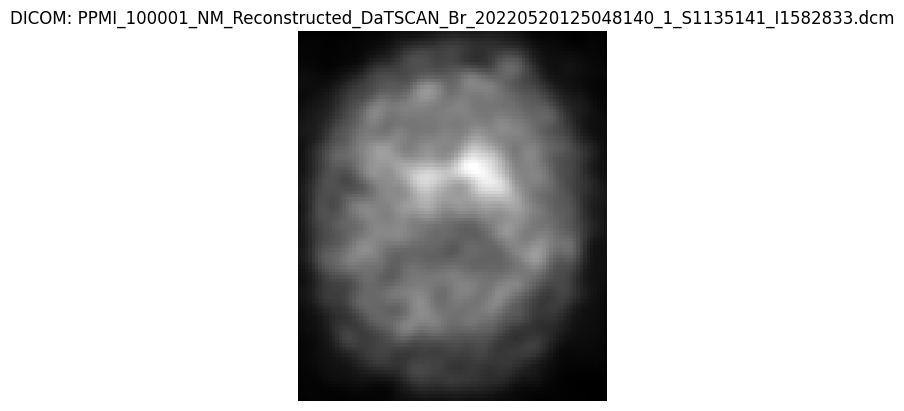

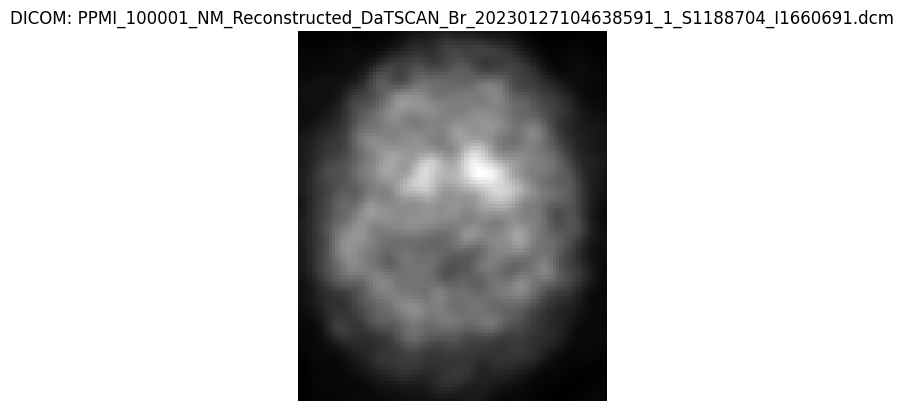

In [3]:
base_path = "Dataset/Images/PPMI"

displayed_count = 0
MAX_DISPLAYED = 5

for patient_id in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for scan_type in os.listdir(patient_path):
        scan_type_path = os.path.join(patient_path, scan_type)
        if not os.path.isdir(scan_type_path):
            continue

        for scan_date in os.listdir(scan_type_path):
            scan_date_path = os.path.join(scan_type_path, scan_date)
            if not os.path.isdir(scan_date_path):
                continue

            for image_id in os.listdir(scan_date_path):
                image_folder_path = os.path.join(scan_date_path, image_id)
                if not os.path.isdir(image_folder_path):
                    continue

                for file in os.listdir(image_folder_path):
                    if file.lower().endswith(".dcm"):
                        dicom_file = os.path.join(image_folder_path, file)
                        display_dicom_image(dicom_file)
                        displayed_count += 1
                        break

                if displayed_count >= MAX_DISPLAYED:
                    break
            if displayed_count >= MAX_DISPLAYED:
                break
        if displayed_count >= MAX_DISPLAYED:
            break
    if displayed_count >= MAX_DISPLAYED:
        break

### 1. Conversion from DICOM to NIfTI

In [4]:
def display_nifti_img(data, ax=None, title="", axis="z"):
    # Take middle slice in x-axis
    if axis == "x":
        x_middle = data.shape[0] // 2
        slice_img = data[x_middle, :, :]

    # Take middle slice in y-axis
    elif axis == "y":
        y_middle = data.shape[1] // 2
        slice_img = data[:, y_middle, :]

    # Take middle slice in z-axis
    else:
        z_middle = data.shape[2] // 2
        slice_img = data[:, :, z_middle]

    if ax is None:
        # Display standalone
        plt.imshow(np.rot90(slice_img), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()
    else:
        # Display in provided axis
        ax.imshow(np.rot90(slice_img), cmap='gray')
        ax.set_title(title)
        ax.axis('off')


[1/3839] Converting: patient 100001 - image I1452480....


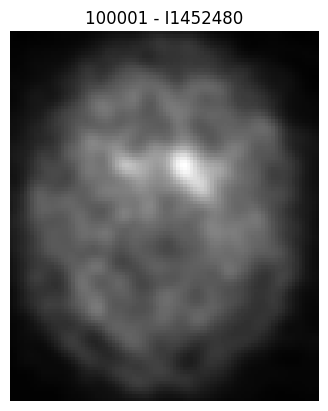


[2/3839] Converting: patient 100001 - image I1518598....


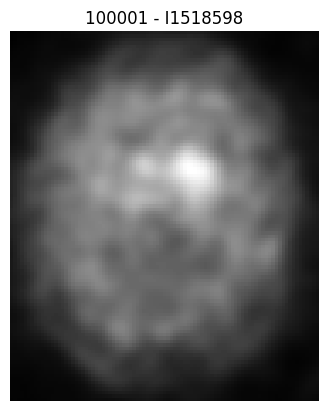


[3/3839] Converting: patient 100001 - image I1530341....


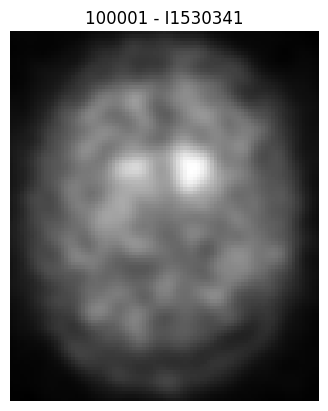


[4/3839] Converting: patient 100001 - image I1582833....

[5/3839] Converting: patient 100001 - image I1660691....

[6/3839] Converting: patient 100001 - image I10960001....

[7/3839] Converting: patient 100002 - image I1474774....

[8/3839] Converting: patient 100002 - image I1537899....

[9/3839] Converting: patient 100004 - image I1461542....

[10/3839] Converting: patient 100005 - image I1461543....

[11/3839] Converting: patient 100005 - image I1548448....

[12/3839] Converting: patient 100006 - image I1461544....

[13/3839] Converting: patient 100006 - image I1537900....

[14/3839] Converting: patient 100006 - image I10380466....

[15/3839] Converting: patient 100007 - image I1461545....

[16/3839] Converting: patient 100007 - image I1548449....

[17/3839] Converting: patient 100007 - image I10380467....

[18/3839] Converting: patient 100012 - image I1461546....

[19/3839] Converting: patient 100012 - image I1573146....

[20/3839] Converting: patient 100012 - image I1671552....


In [ ]:
total_images = 3839
processed_count = 0
displayed_count = 0
failed_images = []

nifti_path = "Dataset/Images/Converted_NIfTI"
os.makedirs(nifti_path, exist_ok=True)

def convert_with_dcm2niix(dicom_folder, output_file):
    try:
        output_dir = os.path.dirname(output_file)
        os.makedirs(output_dir, exist_ok=True)

        subprocess.run([
            "dcm2niix/dcm2niix.exe",
            "-z", "y",                # gzip compress
            "-f", "temp_convert",     # temporary filename
            "-o", output_dir,         # output directory
            dicom_folder
        ], check=True)

        # rename files by image id
        nii_file = None
        json_file = None

        for f in os.listdir(output_dir):
            if f.startswith("temp_convert") and f.endswith(".nii.gz"):
                nii_file = f
            elif f.startswith("temp_convert") and f.endswith(".json"):
                json_file = f

        if nii_file:
            os.rename(os.path.join(output_dir, nii_file), output_file)

            if json_file:
                json_output = os.path.splitext(os.path.splitext(output_file)[0])[0] + ".json"
                os.rename(
                    os.path.join(output_dir, json_file),
                    json_output
                )
            return True

        print(f"[✘] No NIfTI file generated for {dicom_folder}")
        return False


    except subprocess.CalledProcessError as e:
        print(f"[✘] dcm2niix failed for {dicom_folder}: {e}")
        return False


for patient_id in os.listdir(base_path):
    patient_path = os.path.join(base_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    for scan_type in os.listdir(patient_path):
        scan_type_path = os.path.join(patient_path, scan_type)
        if not os.path.isdir(scan_type_path):
            continue

        for scan_date in os.listdir(scan_type_path):
            date_path = os.path.join(scan_type_path, scan_date)
            if not os.path.isdir(date_path):
                continue

            for image_id in os.listdir(date_path):
                image_folder = os.path.join(date_path, image_id)
                if not os.path.isdir(image_folder):
                    continue

                processed_count += 1
                print(f"\n[{processed_count}/{total_images}] Converting: patient {patient_id} - image {image_id}....")

                patient_output_dir = os.path.join(nifti_path, patient_id)
                os.makedirs(patient_output_dir, exist_ok=True)
                output_file = os.path.join(patient_output_dir, f"{image_id}.nii.gz")

                try:
                    if not convert_with_dcm2niix(image_folder, output_file):
                        failed_images.append(f"{patient_id}/{image_id}")
                        continue

                    # Display NIfTI images
                    if displayed_count < MAX_DISPLAYED and os.path.exists(output_file):
                        try:
                            img = nib.load(output_file)
                            data = img.get_fdata()
                            display_nifti_img(data, title=f"{patient_id} - {image_id}")
                            displayed_count += 1
                        except Exception as e:
                            print(f"[✘] Failed to display {output_file}: {e}")
                            failed_images.append(f"{patient_id}/{image_id}")

                except Exception as e:
                    print(f"[✘] Unexpected error processing {patient_id}/{image_id}: {e}")
                    failed_images.append(f"{patient_id}/{image_id}")


# ==== FINAL SUMMARY ====
print("\n" + "="*50)
if not failed_images:
    print("✅ All images converted successfully.")
else:
    print(f"⚠ {len(failed_images)} images failed to convert:")
    for img in failed_images:
        print(f" - {img}")

### 2. Background Thresholding


[1/3837] Thresholding: patient 100001 - image I10960001....
→ Used threshold value: 1.7646322250366206
→ Amount of 0s in original: 98243
→ Amount of 0s in thresholded: 270789


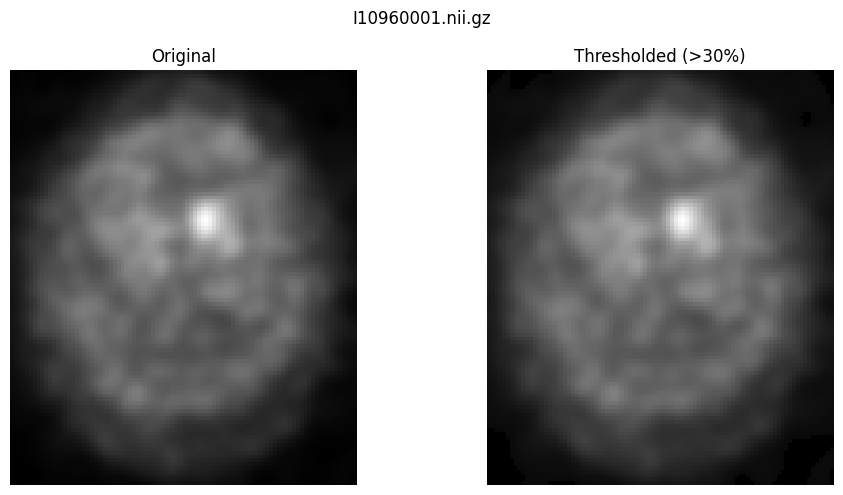


[2/3837] Thresholding: patient 100001 - image I1452480....
→ Used threshold value: -24769.600000000035
→ Amount of 0s in original: 9
→ Amount of 0s in thresholded: 270798


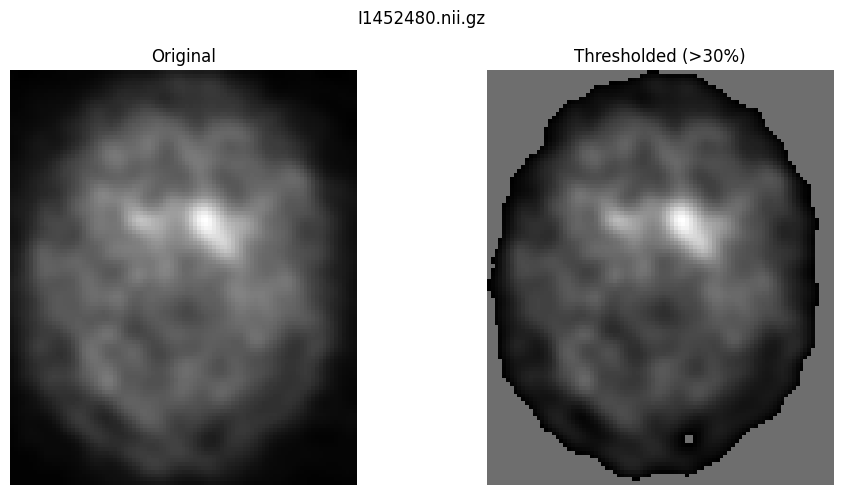


[3/3837] Thresholding: patient 100001 - image I1518598....
→ Used threshold value: 1645.0
→ Amount of 0s in original: 8940
→ Amount of 0s in thresholded: 270734


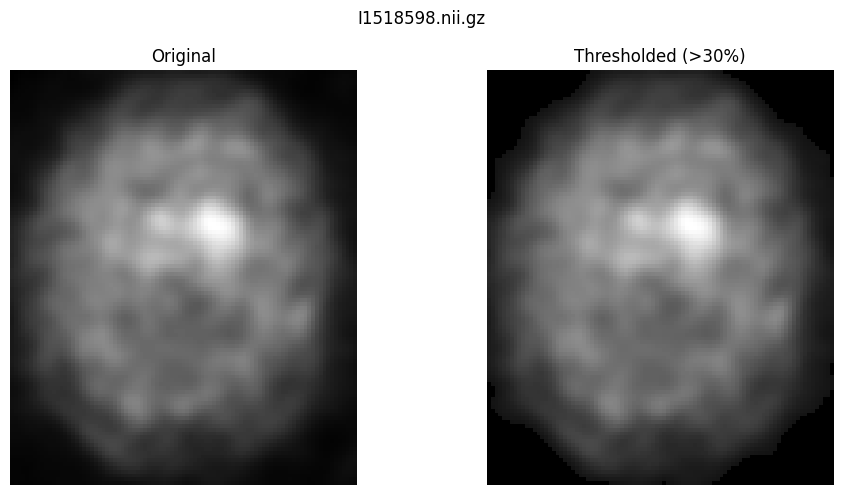


[4/3837] Thresholding: patient 100001 - image I1530341....

[5/3837] Thresholding: patient 100001 - image I1582833....

[6/3837] Thresholding: patient 100001 - image I1660691....

[7/3837] Thresholding: patient 100002 - image I1474774....

[8/3837] Thresholding: patient 100002 - image I1537899....

[9/3837] Thresholding: patient 100004 - image I1461542....

[10/3837] Thresholding: patient 100005 - image I1461543....

[11/3837] Thresholding: patient 100005 - image I1548448....

[12/3837] Thresholding: patient 100006 - image I10380466....

[13/3837] Thresholding: patient 100006 - image I1461544....

[14/3837] Thresholding: patient 100006 - image I1537900....

[15/3837] Thresholding: patient 100007 - image I10380467....

[16/3837] Thresholding: patient 100007 - image I1461545....

[17/3837] Thresholding: patient 100007 - image I1548449....

[18/3837] Thresholding: patient 100012 - image I1461546....

[19/3837] Thresholding: patient 100012 - image I1573146....

[20/3837] Thresholding: pat

In [ ]:
# Count total NIfTI files first
total_images = sum(
    1 for root, dirs, files in os.walk(nifti_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_images = []


percentile = 30
thresholded_path = "Dataset/Images/Thresholded_NIfTI"
os.makedirs(thresholded_path, exist_ok=True)

def apply_dynamic_threshold(input_file, output_file, percentile=30):
    global displayed_count, MAX_DISPLAYED
    try:
        # Load image
        img = nib.load(input_file)
        data = img.get_fdata()

        # Calculate dynamic threshold (ignoring zero voxels)
        # threshold = np.percentile(data[data > 0], percentile)
        threshold = np.percentile(data, percentile)

        # Apply threshold
        thresholded_data = np.where(data >= threshold, data, 0)

        # Save thresholded image
        nib.save(
            nib.Nifti1Image(thresholded_data, affine=img.affine, header=img.header),
            output_file
        )

        if displayed_count < MAX_DISPLAYED:
            # Print info
            print("→ Used threshold value:", threshold)
            print("→ Amount of 0s in original:", np.sum(data == 0))
            print("→ Amount of 0s in thresholded:", np.sum(thresholded_data == 0))

            # Display BEFORE/AFTER
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))
            fig.suptitle(os.path.basename(input_file))

            display_nifti_img(data, ax=axs[0], title="Original")
            display_nifti_img(thresholded_data, ax=axs[1], title=f"Thresholded (>{percentile}%)")

            plt.tight_layout()
            plt.show()

            displayed_count += 1

        return True

    except Exception as e:
        print(f"[✘] Failed on {input_file}: {e}")
        return False


# Process all NIfTI files
for root, dirs, files in os.walk(nifti_path):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            processed_count += 1

            patient_id = os.path.basename(root)
            img_id = os.path.splitext(os.path.splitext(file)[0])[0]  # remove .nii.gz
            print(f"\n[{processed_count}/{total_images}] Thresholding: patient {patient_id} - image {img_id}....")

            input_path = os.path.join(root, file)

            patient_output_dir = os.path.join(thresholded_path, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)
            output_file = os.path.join(patient_output_dir, f"{img_id}.nii.gz")

            if not apply_dynamic_threshold(input_path, output_file, percentile):
                failed_images.append(f"{patient_id}/{img_id}")


# ==== FINAL SUMMARY ====
print("\n" + "="*50)
if not failed_images:
    print("✅ All images thresholded successfully.")
else:
    print(f"⚠ {len(failed_images)} images failed to threshold:")
    for img in failed_images:
        print(f" - {img}")

### 3. Denoising using NLM

⚠ 3 images failed to denoise:
 - 3372/I1317554
 - 4092/I449046
 - 50028/I1273880
 

[✔] Skipping (already processed): 100001 - I10960001
[✔] Skipping (already processed): 100001 - I1452480
[✔] Skipping (already processed): 100001 - I1518598
[✔] Skipping (already processed): 100001 - I1530341
[✔] Skipping (already processed): 100001 - I1582833
[✔] Skipping (already processed): 100001 - I1660691
[✔] Skipping (already processed): 100002 - I1474774
[✔] Skipping (already processed): 100002 - I1537899
[✔] Skipping (already processed): 100004 - I1461542
[✔] Skipping (already processed): 100005 - I1461543
[✔] Skipping (already processed): 100005 - I1548448
[✔] Skipping (already processed): 100006 - I10380466
[✔] Skipping (already processed): 100006 - I1461544
[✔] Skipping (already processed): 100006 - I1537900
[✔] Skipping (already processed): 100007 - I10380467
[✔] Skipping (already processed): 100007 - I1461545
[✔] Skipping (already processed): 100007 - I1548449
[✔] Skipping (already processed): 100012 - I1461546
[✔] Skipping (already processed): 100012 - I1573146
[✔] Skipp

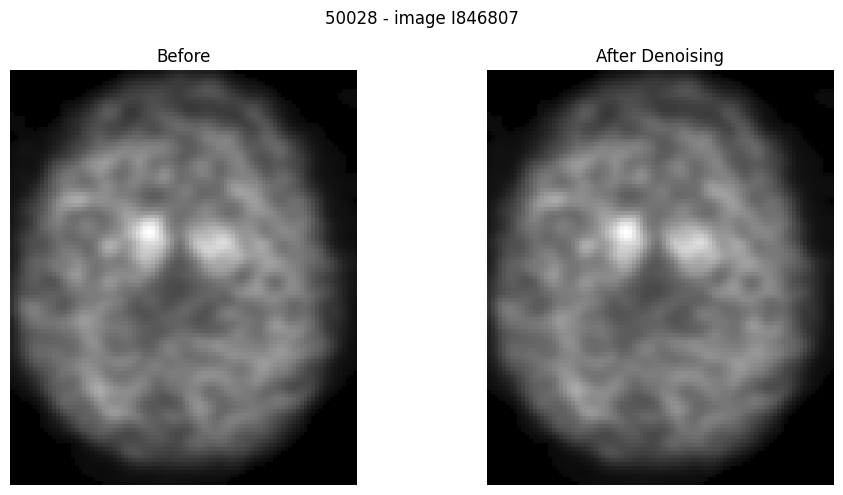


[3628/3834] Denoising: patient 5003 - image I1333720....


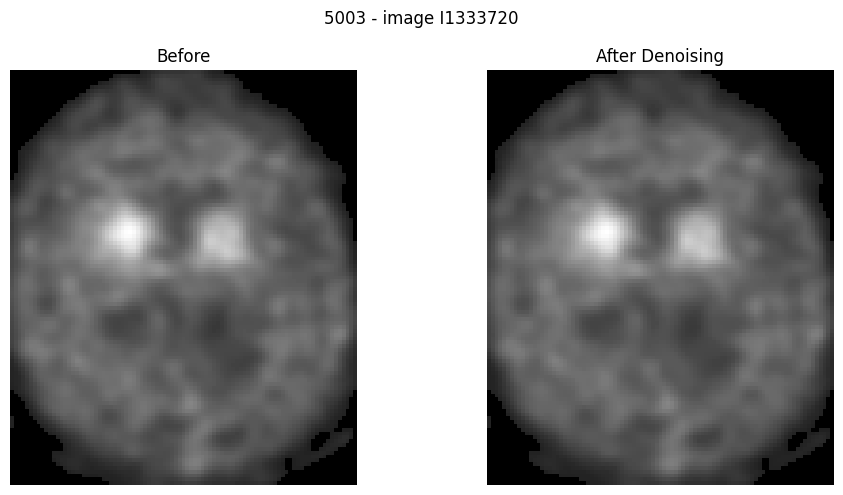


[3629/3834] Denoising: patient 5003 - image I1344250....


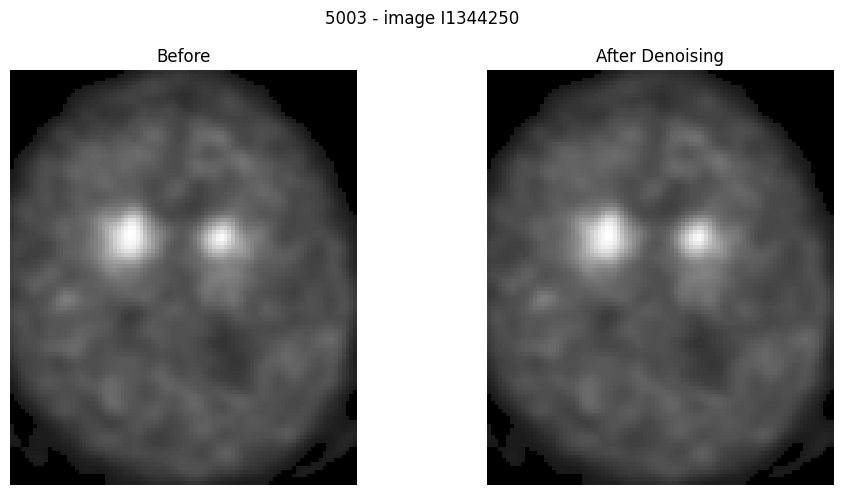


[3630/3834] Denoising: patient 5003 - image I1474795....

[3631/3834] Denoising: patient 5004 - image I1333721....

[3632/3834] Denoising: patient 5004 - image I1344251....

[3633/3834] Denoising: patient 50044 - image I1145729....

[3634/3834] Denoising: patient 50044 - image I1333771....

[3635/3834] Denoising: patient 50044 - image I765079....

[3636/3834] Denoising: patient 5005 - image I1333722....

[3637/3834] Denoising: patient 5006 - image I1333723....

[3638/3834] Denoising: patient 5006 - image I1344252....

[3639/3834] Denoising: patient 5006 - image I1474796....

[3640/3834] Denoising: patient 5006 - image I1509929....

[3641/3834] Denoising: patient 5007 - image I1333724....

[3642/3834] Denoising: patient 5007 - image I1344253....

[3643/3834] Denoising: patient 5008 - image I1333725....

[3644/3834] Denoising: patient 5008 - image I1344254....

[3645/3834] Denoising: patient 5008 - image I1474797....

[3646/3834] Denoising: patient 50086 - image I453742....

[3647/3834]

In [ ]:
total_images = sum(
    1 for root, dirs, files in os.walk(thresholded_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_denoising = []


denoised_path = "Dataset/Images/Denoised_NIfTI"
os.makedirs(denoised_path, exist_ok=True)

for root, dirs, files in os.walk(thresholded_path):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            processed_count += 1

            patient_id = os.path.basename(root)
            img_id = os.path.splitext(os.path.splitext(file)[0])[0]

            input_path = os.path.join(root, file)

            patient_output_dir = os.path.join(denoised_path, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)
            output_file = os.path.join(patient_output_dir, f"{img_id}.nii.gz")

            # === SKIP if already denoised ===
            if os.path.exists(output_file):
                print(f"[✔] Skipping (already processed): {patient_id} - {img_id}")
                continue

            print(f"\n[{processed_count}/{total_images}] Denoising: patient {patient_id} - image {img_id}....")

            try:
                # Load image
                img = nib.load(input_path)
                data = img.get_fdata()

                # Estimate the Gaussian noise standard deviation (ignore zeros)
                sigma_est = np.mean(estimate_sigma(data[data > 0], channel_axis=None))

                # Apply Non-Local Means denoising
                denoised_data = denoise_nl_means(
                    data,
                    h=0.8 * sigma_est,  # smoothing strength
                    patch_size=3,
                    patch_distance=5,
                    channel_axis=None,  # for grayscale image
                    fast_mode=True
                )

                # Display BEFORE/AFTER
                if displayed_count < MAX_DISPLAYED:
                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                    plt.suptitle(f"{patient_id} - image {img_id}")

                    display_nifti_img(data, ax=axes[0], title="Before")
                    display_nifti_img(denoised_data, ax=axes[1], title="After Denoising")

                    plt.tight_layout()
                    plt.show()
                    displayed_count += 1

                # Save denoised image
                nib.save(
                    nib.Nifti1Image(denoised_data, affine=img.affine, header=img.header),
                    output_file
                )

            except Exception as e:
                print(f"[✘] Failed denoising {patient_id}/{img_id}: {e}")
                failed_denoising.append(f"{patient_id}/{img_id}")


# ==== FINAL SUMMARY ====
print("\n" + "="*50)
if not failed_denoising:
    print("✅ All images denoised successfully.")
else:
    print(f"⚠ {len(failed_denoising)} images failed to denoise:")
    for img_name in failed_denoising:
        print(f" - {img_name}")

### 4. Normalizing (Z-score)


[1/3834] Normalizing: patient 100001 - image I10960001....


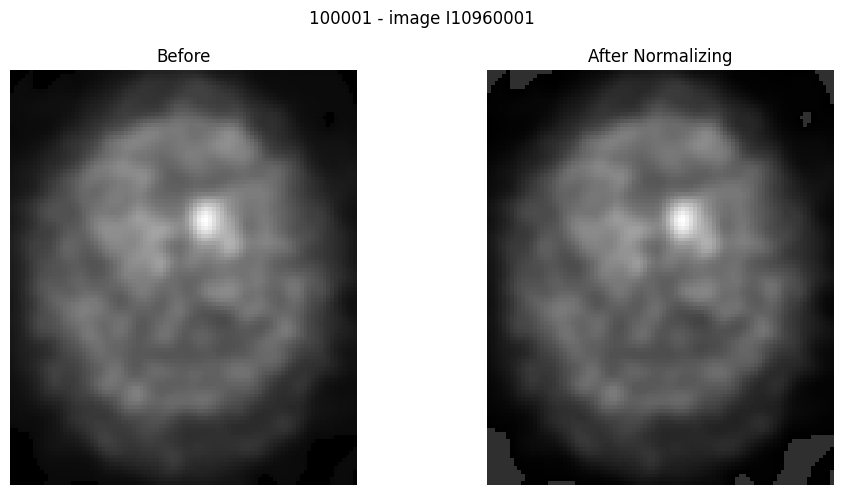


[2/3834] Normalizing: patient 100001 - image I1452480....


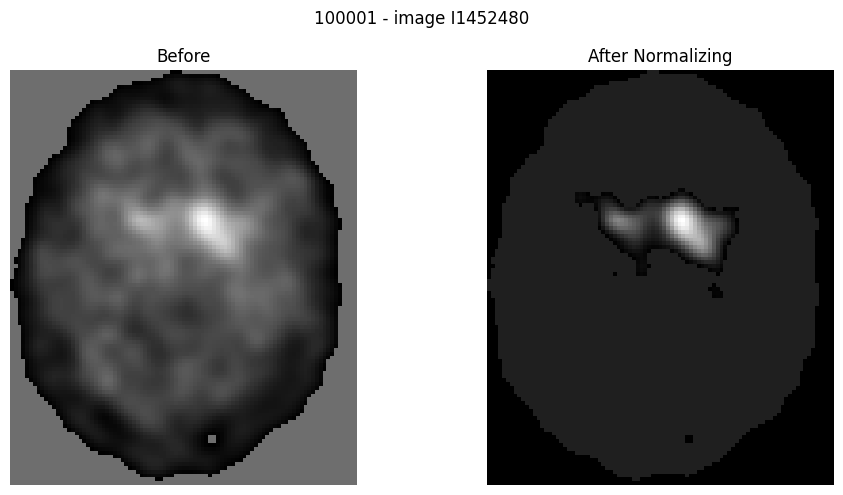


[3/3834] Normalizing: patient 100001 - image I1518598....


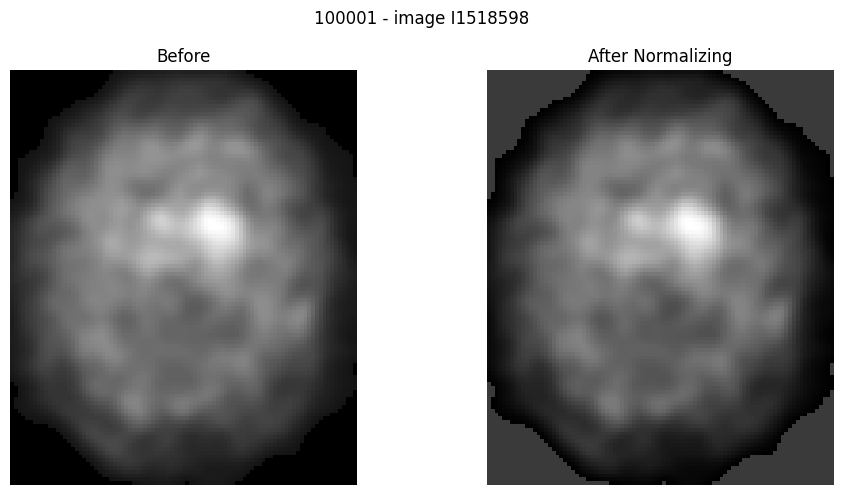


[4/3834] Normalizing: patient 100001 - image I1530341....

[5/3834] Normalizing: patient 100001 - image I1582833....

[6/3834] Normalizing: patient 100001 - image I1660691....

[7/3834] Normalizing: patient 100002 - image I1474774....

[8/3834] Normalizing: patient 100002 - image I1537899....

[9/3834] Normalizing: patient 100004 - image I1461542....

[10/3834] Normalizing: patient 100005 - image I1461543....

[11/3834] Normalizing: patient 100005 - image I1548448....

[12/3834] Normalizing: patient 100006 - image I10380466....

[13/3834] Normalizing: patient 100006 - image I1461544....

[14/3834] Normalizing: patient 100006 - image I1537900....

[15/3834] Normalizing: patient 100007 - image I10380467....

[16/3834] Normalizing: patient 100007 - image I1461545....

[17/3834] Normalizing: patient 100007 - image I1548449....

[18/3834] Normalizing: patient 100012 - image I1461546....

[19/3834] Normalizing: patient 100012 - image I1573146....

[20/3834] Normalizing: patient 100012 - ima

In [ ]:
total_images = sum(
    1 for root, dirs, files in os.walk(denoised_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_normalization = []


normalized_path = "Dataset/Images/Normalized_NIfTI"
os.makedirs(normalized_path, exist_ok=True)

for root, dirs, files in os.walk(denoised_path):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            processed_count += 1

            patient_id = os.path.basename(root)
            img_id = os.path.splitext(os.path.splitext(file)[0])[0]
            print(f"\n[{processed_count}/{total_images}] Normalizing: patient {patient_id} - image {img_id}....")

            input_path = os.path.join(root, file)

            patient_output_dir = os.path.join(normalized_path, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)
            output_file = os.path.join(patient_output_dir, f"{img_id}.nii.gz")

            try:
                # Load image
                img = nib.load(input_path)
                data = img.get_fdata()
                # print("Image's Shape",data.shape)

                # Z-score normalization (only non-zero voxels)
                non_zero_data = data[data > 0]
                mean = np.mean(non_zero_data)
                std = np.std(non_zero_data)

                # Avoid division by zero
                if std == 0:
                    print(f"[⚠️] Std is zero for {patient_id} image {img_id}, skipping normalization.")
                    normalized_data = data
                else:
                    normalized_data = np.where(data > 0, (data - mean) / std, 0)

                # Display BEFORE/AFTER
                if displayed_count < MAX_DISPLAYED:
                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                    plt.suptitle(f"{patient_id} - image {img_id}")

                    display_nifti_img(data, ax=axes[0], title="Before")
                    display_nifti_img(normalized_data, ax=axes[1], title="After Normalizing")

                    plt.tight_layout()
                    plt.show()

                    displayed_count += 1

                # Save normalized file
                nib.save(
                    nib.Nifti1Image(normalized_data, affine=img.affine, header=img.header),
                    output_file
                )

            except Exception as e:
                print(f"[✘] Failed to normalize {patient_id}/{img_id}: {e}")
                failed_normalization.append(f"{patient_id}/{img_id}")


# ==== FINAL SUMMARY ====
print("\n" + "="*50)
if not failed_normalization:
    print("✅ All images normalized successfully.")
else:
    print(f"⚠ {len(failed_normalization)} images failed to normalize:")
    for img_name in failed_normalization:
        print(f" - {img_name}")

### 5. Striatum-centered Cropping


[1/3834] Cropping: patient 100001 - image I10960001....


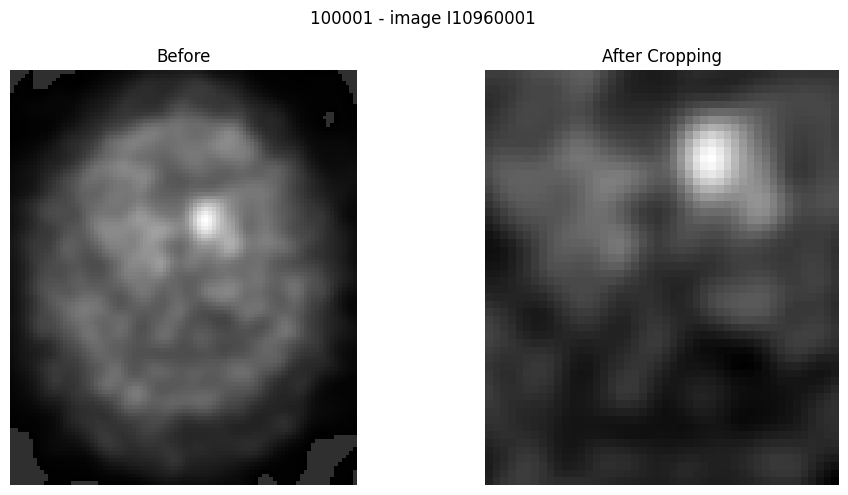


[2/3834] Cropping: patient 100001 - image I1452480....


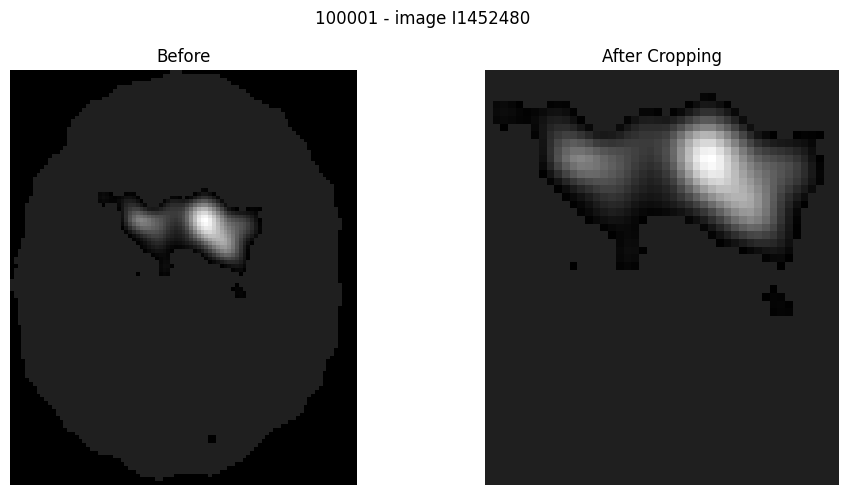


[3/3834] Cropping: patient 100001 - image I1518598....


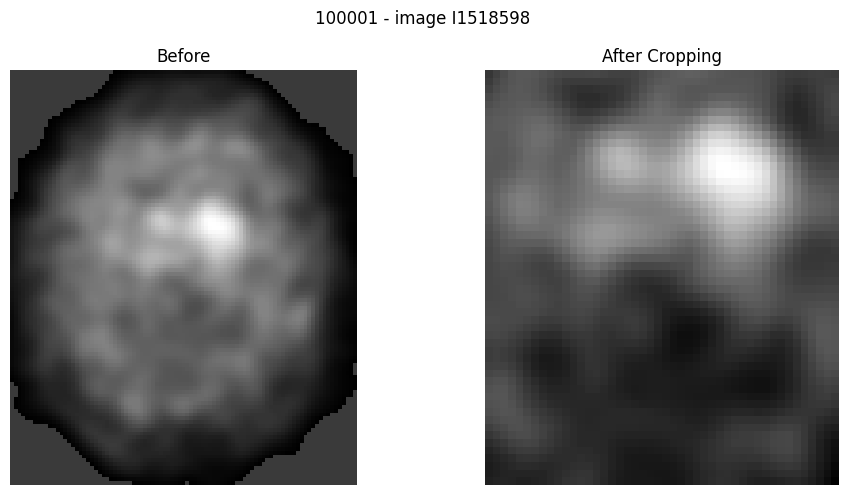


[4/3834] Cropping: patient 100001 - image I1530341....


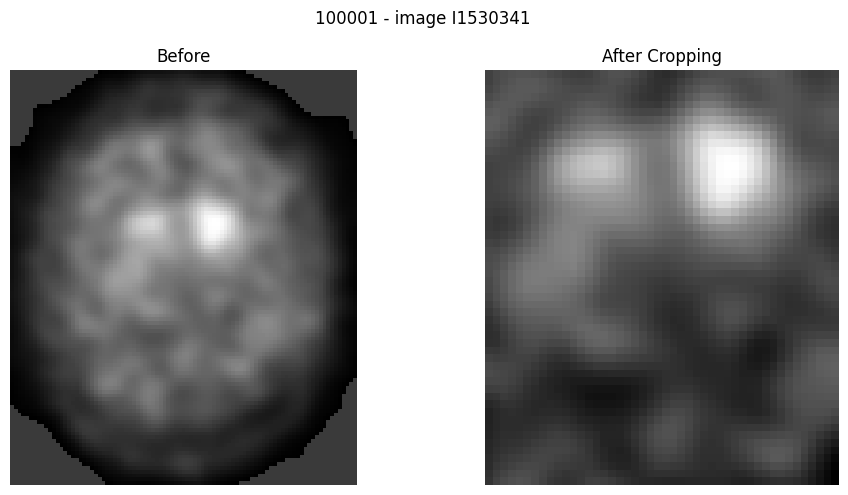


[5/3834] Cropping: patient 100001 - image I1582833....


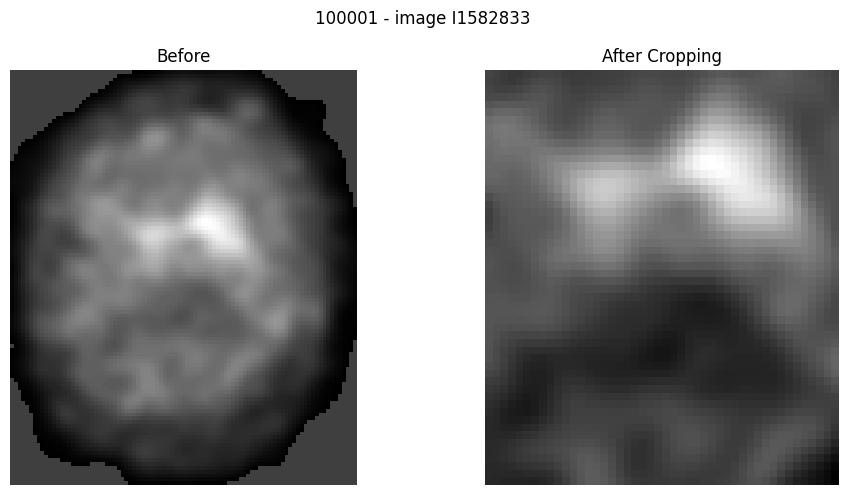


[6/3834] Cropping: patient 100001 - image I1660691....

[7/3834] Cropping: patient 100002 - image I1474774....

[8/3834] Cropping: patient 100002 - image I1537899....

[9/3834] Cropping: patient 100004 - image I1461542....

[10/3834] Cropping: patient 100005 - image I1461543....

[11/3834] Cropping: patient 100005 - image I1548448....

[12/3834] Cropping: patient 100006 - image I10380466....

[13/3834] Cropping: patient 100006 - image I1461544....

[14/3834] Cropping: patient 100006 - image I1537900....

[15/3834] Cropping: patient 100007 - image I10380467....

[16/3834] Cropping: patient 100007 - image I1461545....

[17/3834] Cropping: patient 100007 - image I1548449....

[18/3834] Cropping: patient 100012 - image I1461546....

[19/3834] Cropping: patient 100012 - image I1573146....

[20/3834] Cropping: patient 100012 - image I1671552....

[21/3834] Cropping: patient 100017 - image I1474775....

[22/3834] Cropping: patient 100017 - image I1619847....

[23/3834] Cropping: patient 1000

In [ ]:
total_images = sum(
    1 for root, dirs, files in os.walk(normalized_path)
    for file in files if file.endswith(".nii") or file.endswith(".nii.gz")
)
processed_count = 0
displayed_count = 0
failed_cropping = []


# ORIGINAL_SHAPE = (91, 109, 91)
CROP_SHAPE = (46, 54, 14)  # (x, y, z)

cropped_path = "Dataset/Images/Cropped_NIfTI"
os.makedirs(cropped_path, exist_ok=True)

for root, dirs, files in os.walk(normalized_path):
    for file in files:
        if file.endswith(".nii") or file.endswith(".nii.gz"):
            processed_count += 1

            patient_id = os.path.basename(root)
            img_id = os.path.splitext(os.path.splitext(file)[0])[0]
            print(f"\n[{processed_count}/{total_images}] Cropping: patient {patient_id} - image {img_id}....")

            input_path = os.path.join(root, file)

            patient_output_dir = os.path.join(cropped_path, patient_id)
            os.makedirs(patient_output_dir, exist_ok=True)
            output_file = os.path.join(patient_output_dir, f"{img_id}.nii.gz")


            try:
                # Load image
                img = nib.load(input_path)
                data = img.get_fdata()

                # Compute center crop coordinates
                cx, cy, cz = np.array(data.shape) // 2
                dx, dy, dz = np.array(CROP_SHAPE) // 2

                # Crop boundaries
                x_start, x_end = cx - dx, cx + dx
                y_start, y_end = cy - dy, cy + dy
                z_start, z_end = cz - dz, cz + dz

                cropped_data = data[x_start:x_end, y_start:y_end, z_start:z_end]

                # Display BEFORE/AFTER
                if displayed_count < MAX_DISPLAYED:
                    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
                    plt.suptitle(f"{patient_id} - image {img_id}")

                    display_nifti_img(data, ax=axes[0], title="Before")
                    display_nifti_img(cropped_data, ax=axes[1], title="After Cropping")

                    plt.tight_layout()
                    plt.show()

                    displayed_count += 1

                # Save cropped image
                nib.save(
                    nib.Nifti1Image(cropped_data, affine=img.affine, header=img.header),
                    output_file
                )

            except Exception as e:
                print(f"[✘] Failed to crop {patient_id}/{img_id}: {e}")
                failed_cropping.append(f"{patient_id}/{img_id}")


# ==== FINAL SUMMARY ====
print("\n" + "="*50)
if not failed_cropping:
    print("✅ All images cropped successfully.")
else:
    print(f"⚠ {len(failed_cropping)} images failed to crop:")
    for img_name in failed_cropping:
        print(f" - {img_name}")

## Merge all PPMI_ folders

### check for duplicates patients

In [ ]:
from collections import defaultdict

# Path where PPMI_1 to PPMI_5 folders live
base_path = "Dataset/Images"

# Store patients by which PPMI folder they appear in
patient_folders = defaultdict(list)

# Loop over each PPMI folder
for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path) and folder_name.startswith("PPMI_"):
        # Each patient is usually a subfolder (adjust if stored differently)
        for patient_id in os.listdir(folder_path):
            patient_folders[patient_id].append(folder_name)

# Find duplicates
duplicates = {pid: locations for pid, locations in patient_folders.items() if len(locations) > 1}

# Report results
if duplicates:
    print("⚠ Found patients in multiple PPMI folders:")
    for pid, locations in duplicates.items():
        print(f" - Patient {pid} found in: {', '.join(locations)}")
else:
    print("✅ No duplicate patients found across PPMI_1 to PPMI_5")


⚠ Found patients in multiple PPMI folders:
 - Patient 100001 found in: PPMI_1, PPMI_2, PPMI_3, PPMI_5
 - Patient 100005 found in: PPMI_1, PPMI_3
 - Patient 100006 found in: PPMI_1, PPMI_2, PPMI_5
 - Patient 100012 found in: PPMI_1, PPMI_3
 - Patient 100017 found in: PPMI_1, PPMI_3
 - Patient 100018 found in: PPMI_1, PPMI_4
 - Patient 100268 found in: PPMI_1, PPMI_3, PPMI_4
 - Patient 100889 found in: PPMI_1, PPMI_3, PPMI_4
 - Patient 100891 found in: PPMI_1, PPMI_2
 - Patient 100898 found in: PPMI_1, PPMI_2, PPMI_3
 - Patient 100911 found in: PPMI_1, PPMI_3, PPMI_4
 - Patient 100952 found in: PPMI_1, PPMI_2, PPMI_5
 - Patient 101018 found in: PPMI_1, PPMI_5
 - Patient 101026 found in: PPMI_1, PPMI_3, PPMI_4
 - Patient 101038 found in: PPMI_1, PPMI_2, PPMI_5
 - Patient 101047 found in: PPMI_1, PPMI_2, PPMI_3, PPMI_4
 - Patient 101070 found in: PPMI_1, PPMI_5
 - Patient 101174 found in: PPMI_1, PPMI_3, PPMI_5
 - Patient 101179 found in: PPMI_1, PPMI_3, PPMI_5
 - Patient 101186 found in: 

### check for duplicates images per patient

In [18]:
# Step 1: Map patients to which PPMI folders they appear in
patient_folders = defaultdict(list)

for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path) and folder_name.startswith("PPMI_"):
        for patient_id in os.listdir(folder_path):
            patient_path = os.path.join(folder_path, patient_id)
            if os.path.isdir(patient_path):
                patient_folders[patient_id].append(patient_path)

# Step 2: Check duplicates by image_id (last folder name)
duplicates = {pid: paths for pid, paths in patient_folders.items() if len(paths) > 1}

if not duplicates:
    print("✅ No duplicate patients found.")
else:
    print(f"⚠ Found {len(duplicates)} duplicate patients.\n")

    for patient_id, paths in duplicates.items():
        image_id_sets = []

        for path in paths:
            image_ids = set()
            for root, dirs, files in os.walk(path):
                # If this folder has no subfolders and contains files, it's an image_id folder
                if files and not dirs:
                    image_id = os.path.basename(root)
                    image_ids.add(image_id)
            image_id_sets.append(image_ids)

        # Compare all sets of image_ids
        identical = all(image_id_sets[0] == ids for ids in image_id_sets[1:])

        print(f"Patient {patient_id}: {'YES - identical image IDs' if identical else 'NO - different image IDs'}")


⚠ Found 857 duplicate patients.

Patient 100001: NO - different image IDs
Patient 100005: NO - different image IDs
Patient 100006: NO - different image IDs
Patient 100012: NO - different image IDs
Patient 100017: NO - different image IDs
Patient 100018: NO - different image IDs
Patient 100268: NO - different image IDs
Patient 100889: NO - different image IDs
Patient 100891: NO - different image IDs
Patient 100898: NO - different image IDs
Patient 100911: NO - different image IDs
Patient 100952: NO - different image IDs
Patient 101018: NO - different image IDs
Patient 101026: NO - different image IDs
Patient 101038: NO - different image IDs
Patient 101047: NO - different image IDs
Patient 101070: NO - different image IDs
Patient 101174: NO - different image IDs
Patient 101179: NO - different image IDs
Patient 101186: NO - different image IDs
Patient 101221: NO - different image IDs
Patient 101279: NO - different image IDs
Patient 101295: NO - different image IDs
Patient 101330: NO - dif

### merge all 5 folders

In [ ]:
import shutil


# Destination: merged single PPMI folder
output_dir = os.path.join(base_path, "PPMI")
os.makedirs(output_dir, exist_ok=True)

# Map: patient_id -> set of image_ids (to avoid duplicates)
patient_image_ids = defaultdict(set)

# Walk through all PPMI folders
for folder_name in sorted(os.listdir(base_path)):
    folder_path = os.path.join(base_path, folder_name)

    if os.path.isdir(folder_path) and folder_name.startswith("PPMI_"):
        for patient_id in os.listdir(folder_path):
            patient_path = os.path.join(folder_path, patient_id)
            if not os.path.isdir(patient_path):
                continue

            # Destination patient folder
            merged_patient_path = os.path.join(output_dir, patient_id)
            os.makedirs(merged_patient_path, exist_ok=True)

            # Walk through the substructure of each patient
            for scan_type in os.listdir(patient_path):
                scan_type_path = os.path.join(patient_path, scan_type)
                if not os.path.isdir(scan_type_path):
                    continue

                for date_folder in os.listdir(scan_type_path):
                    date_path = os.path.join(scan_type_path, date_folder)
                    if not os.path.isdir(date_path):
                        continue

                    for image_id in os.listdir(date_path):
                        image_id_path = os.path.join(date_path, image_id)
                        if not os.path.isdir(image_id_path):
                            continue

                        # Skip duplicate image_ids for the same patient
                        if image_id in patient_image_ids[patient_id]:
                            continue

                        # Mark image_id as seen
                        patient_image_ids[patient_id].add(image_id)

                        # Destination path preserving structure
                        merged_image_path = os.path.join(
                            merged_patient_path, scan_type, date_folder, image_id
                        )
                        os.makedirs(os.path.dirname(merged_image_path), exist_ok=True)

                        # Copy the entire image_id folder
                        shutil.copytree(image_id_path, merged_image_path)

print("✅ Merge complete! Output stored in:", output_dir)

✅ Merge complete! Output stored in: Dataset\PPMI_MERGED


### verify total number of patients and images

#### in the 5 folders

In [ ]:
ppmi_folders = [
    "Dataset/Images/PPMI_1",
    "Dataset/Images/PPMI_2",
    "Dataset/Images/PPMI_3",
    "Dataset/Images/PPMI_4",
    "Dataset/Images/PPMI_5"
]

all_patients = set()
total_unique_images = 0

for folder in ppmi_folders:
    for patient_id in os.listdir(folder):
        patient_path = os.path.join(folder, patient_id)
        if not os.path.isdir(patient_path):
            continue

        all_patients.add(patient_id)

        # Track unique image IDs for this patient inside this folder
        patient_image_ids = set()

        for scan_type in os.listdir(patient_path):
            scan_type_path = os.path.join(patient_path, scan_type)
            if not os.path.isdir(scan_type_path):
                continue

            for date_folder in os.listdir(scan_type_path):
                date_path = os.path.join(scan_type_path, date_folder)
                if not os.path.isdir(date_path):
                    continue

                for image_id in os.listdir(date_path):
                    if os.path.isdir(os.path.join(date_path, image_id)):
                        patient_image_ids.add(image_id)

        total_unique_images += len(patient_image_ids)

print(f"📌 Total unique patients: {len(all_patients)}")
print(f"📌 Total unique image IDs: {total_unique_images}")

📌 Total unique patients: 2033
📌 Total unique image IDs: 3839


#### in the merged folder

In [6]:
merged_path = "Dataset/Images/PPMI"

all_patients = set()
total_unique_images = 0

for patient_id in os.listdir(merged_path):
    patient_path = os.path.join(merged_path, patient_id)
    if not os.path.isdir(patient_path):
        continue

    all_patients.add(patient_id)

    # Track unique image IDs for this patient
    patient_image_ids = set()

    for scan_type in os.listdir(patient_path):
        scan_type_path = os.path.join(patient_path, scan_type)
        if not os.path.isdir(scan_type_path):
            continue

        for date_folder in os.listdir(scan_type_path):
            date_path = os.path.join(scan_type_path, date_folder)
            if not os.path.isdir(date_path):
                continue

            for image_id in os.listdir(date_path):
                if os.path.isdir(os.path.join(date_path, image_id)):
                    patient_image_ids.add(image_id)

    # Add this patient's unique image count to the total
    total_unique_images += len(patient_image_ids)

print(f"📌 Total unique patients: {len(all_patients)}")
print(f"📌 Total unique image IDs: {total_unique_images}")

📌 Total unique patients: 2033
📌 Total unique image IDs: 3836
